# Dependencias

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from scikitplot.metrics import plot_roc

from datetime import datetime,date
from varclushi import VarClusHi
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf

cf.go_offline()
pd.set_option('display.max_columns',None)

# Lectura de datos

In [2]:
ruta='/home/oscarjarillo/Documentos/Análisis Multivariado/Varios/bank-additional/bank-additional-full.csv'
df=pd.read_csv(ruta,sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.shape

(41188, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

# Definición de variables

In [5]:
df.insert(0,'id',df.index+1)

In [6]:
um = ['id']
vart = ['y']
varc = [v for v in df.columns if df[v].dtype!='object' and v not in um]
vard = [v for v in df.columns if v not in varc and v not in um and v not in vart]

# Análisis exploratorio

## Balanceo de muestra

In [7]:
df['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [8]:
X = pd.concat([d.sample(4640) for _,d in df.groupby('y')]).reset_index(drop=True)
X['y'].value_counts()

no     4640
yes    4640
Name: y, dtype: int64

## Variables continuas

### Valores nulos

In [9]:
nulos = 1-X.describe().T[['count']]/len(X)
nulos

,count
id,0.0
age,0.0
duration,0.0
campaign,0.0
pdays,0.0
previous,0.0
emp.var.rate,0.0
cons.price.idx,0.0
cons.conf.idx,0.0
euribor3m,0.0


## Variables discretas

### Valores nulos

In [10]:
X.dropna().shape,X.shape

((9280, 22), (9280, 22))

### Conversión a variables numéricas 

In [11]:
for v in vard:
    for a,b in zip(list(X[v].unique()),range(1,len(list(X[v].unique()))+1)):
        X.loc[X[v]==a,v]=b
    X[v] = pd.to_numeric(X[v])

## Cambio de espacio $\mathcal{X}_{[0,1]}$

In [12]:
sc = MinMaxScaler()
sc.fit(X[varc+vard])

MinMaxScaler()

In [13]:
X01 = pd.DataFrame(sc.transform(X[varc+vard]),columns=varc+vard)
X01[um+vart] = X[um+vart]

## Selección de variables con mejor poder predictivo

In [14]:
sk = SelectKBest(k=len(varc+vard))
sk.fit(X[varc+vard],X[vart[0]])

SelectKBest(k=20)

In [15]:
pd.DataFrame(zip(varc+vard,sk.scores_),columns=['var','score']).set_index('var').sort_values(by='score',
                                                        ascending=False).iplot(kind='bar',color='orange')

In [16]:
sk = SelectKBest(k=10)
sk.fit(X[varc+vard],X[vart[0]])

SelectKBest()

In [17]:
best = [a for a,b in zip(varc+vard,sk.get_support()) if b]
best

['duration',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'euribor3m',
 'nr.employed',
 'contact',
 'month',
 'poutcome']

## Multicolinealidad

vc = VarClusHi(df=X[best],feat_list=best).varclus().rsquare.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
display(vc)
best = sorted(vc.groupby('Cluster').first()['Variable'])
best

## Varianza nula

In [18]:
vt = VarianceThreshold()
vt.fit(X[best])

VarianceThreshold()

In [19]:
fuera = [a for a,b in zip(best,vt.get_support())if not b]
fuera

[]

## Valores extremos

array([[<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'pdays'}>,
        <AxesSubplot:title={'center':'previous'}>],
       [<AxesSubplot:title={'center':'emp.var.rate'}>,
        <AxesSubplot:title={'center':'cons.price.idx'}>,
        <AxesSubplot:title={'center':'euribor3m'}>],
       [<AxesSubplot:title={'center':'nr.employed'}>,
        <AxesSubplot:title={'center':'contact'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'poutcome'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

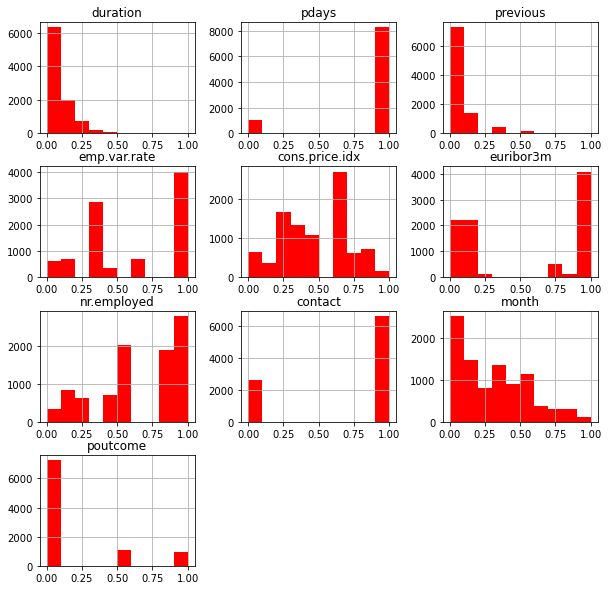

In [20]:
X01[best].hist(figsize=(10,10),color='red')

In [21]:
for v,li,ls in X01[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X01[f'ex_{v}'] = ((X01[v]<li)|(X01[v]>ls)).astype(int)
X01['ex_'] = X01.filter(like='ex_').max(axis=1)
X01['ex_'].value_counts(1)

0    0.947845
1    0.052155
Name: ex_, dtype: float64

In [22]:
for v,li,ls in X01[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X01.loc[X01[v]<li,v]=np.nan
    X01.loc[X01[v]>ls,v]=np.nan

In [23]:
imp = SimpleImputer(strategy='median')
imp.fit(X01[best])

SimpleImputer(strategy='median')

In [24]:
Xi = pd.DataFrame(imp.transform(X01[best]),columns=best)
Xi[um+vart] = X01[um+vart]

In [25]:
ks = pd.DataFrame(map(lambda v:(v,stats.ks_2samp(Xi[v],X01[v].dropna()).statistic),best),columns=['var','ks']).set_index('var')
ks.sort_values(by='ks',ascending=False,inplace=True)
ks

,ks
var,
duration,0.010002
euribor3m,0.006856
cons.price.idx,0.003231
previous,0.001374
pdays,0.000678
emp.var.rate,0.000000
nr.employed,0.000000
contact,0.000000
month,0.000000


In [26]:
best = [v for v in ks.index if ks['ks'][-1]<0.05]
best

['duration',
 'euribor3m',
 'cons.price.idx',
 'previous',
 'pdays',
 'emp.var.rate',
 'nr.employed',
 'contact',
 'month',
 'poutcome']

array([[<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'euribor3m'}>,
        <AxesSubplot:title={'center':'cons.price.idx'}>],
       [<AxesSubplot:title={'center':'previous'}>,
        <AxesSubplot:title={'center':'pdays'}>,
        <AxesSubplot:title={'center':'emp.var.rate'}>],
       [<AxesSubplot:title={'center':'nr.employed'}>,
        <AxesSubplot:title={'center':'contact'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'poutcome'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

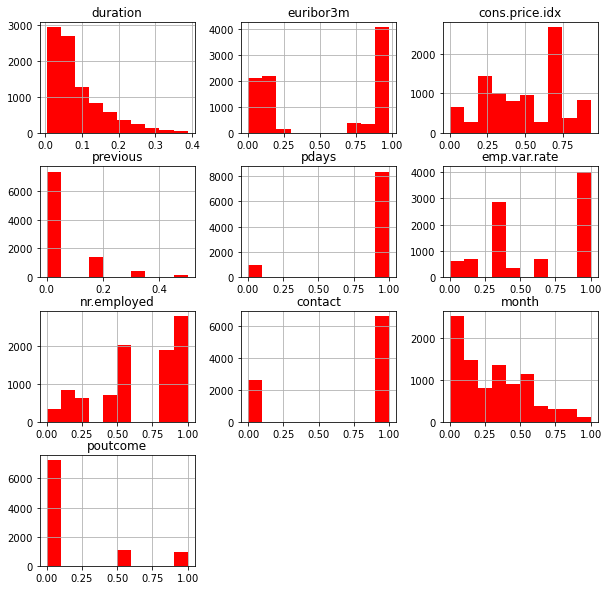

In [27]:
Xi[best].hist(figsize=(10,10),color='red')

# Partición de entrenamiento

In [28]:
Sn,Sv = train_test_split(Xi[um+best+vart],train_size=0.7)
Sn.reset_index(drop=True,inplace=True)
Sv.reset_index(drop=True,inplace=True)

# Aprendizaje 

## Pasivo-Agresivo

In [29]:
hp = dict(max_iter=(1000,2000),
         fit_intercept=[True,False],
         C=np.arange(0.1,5,0.1))

modelo = PassiveAggressiveClassifier()

grid = GridSearchCV(param_grid=hp,
                   cv=10,
                   scoring='accuracy',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [30]:
grid.fit(Sn[best],Sn[vart[0]])

Fitting 10 folds for each of 196 candidates, totalling 1960 fits


GridSearchCV(cv=10, estimator=PassiveAggressiveClassifier(), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
                         'fit_intercept': [True, False],
                         'max_iter': (1000, 2000)},
             scoring='accuracy', verbose=True)

In [31]:
grid.best_params_

{'C': 0.1, 'fit_intercept': False, 'max_iter': 2000}

In [32]:
modelo = grid.best_estimator_
modelo

PassiveAggressiveClassifier(C=0.1, fit_intercept=False, max_iter=2000)

In [33]:
modelo.fit(Sn[best],Sn[vart[0]])

PassiveAggressiveClassifier(C=0.1, fit_intercept=False, max_iter=2000)

### Validación

In [34]:
Sn['y^'] = modelo.predict(Sn[best])
Sv['y^'] = modelo.predict(Sv[best]) 

In [35]:
print(accuracy_score(y_pred=Sn['y^'],y_true=Sn[vart[0]]))
print(accuracy_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.8137315270935961
0.8160919540229885


In [36]:
print(confusion_matrix(y_pred=Sn['y^'],y_true=Sn[vart[0]]))
print(confusion_matrix(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

[[3002  265]
 [ 945 2284]]
[[1262  111]
 [ 401 1010]]


## Análisis discriminante

In [37]:
modelo = LinearDiscriminantAnalysis()
modelo.fit(Sn[best],Sn[vart[0]])

LinearDiscriminantAnalysis()

### Validación

In [38]:
Sn['y^'] = modelo.predict(Sn[best])
Sv['y^'] = modelo.predict(Sv[best])

Sn['proba'] = modelo.predict_proba(Sn[best])[:,1]
Sv['proba'] = modelo.predict_proba(Sv[best])[:,1]

In [39]:
print(accuracy_score(y_pred=Sn['y^'],y_true=Sn[vart[0]]))
print(accuracy_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.8525246305418719
0.8473419540229885


In [40]:
print(confusion_matrix(y_pred=Sn['y^'],y_true=Sn[vart[0]]))
print(confusion_matrix(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

[[2846  421]
 [ 537 2692]]
[[1185  188]
 [ 237 1174]]


In [41]:
print(roc_auc_score(y_score=Sn['proba'],y_true=Sn[vart[0]]))
print(roc_auc_score(y_score=Sv['proba'],y_true=Sv[vart[0]]))

0.9278155580979421
0.9265915037554786


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

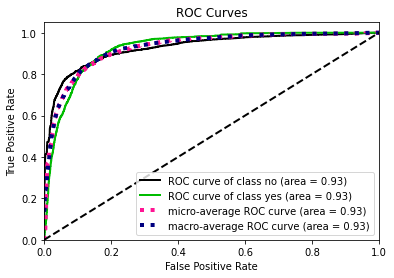

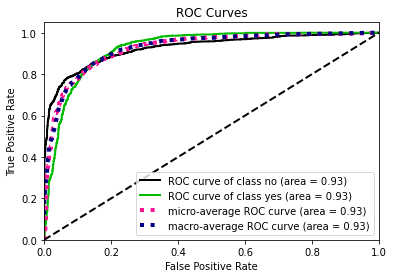

In [42]:
plot_roc(y_probas=modelo.predict_proba(Sn[best]),y_true=Sn[vart[0]])
plot_roc(y_probas=modelo.predict_proba(Sv[best]),y_true=Sv[vart[0]])

<AxesSubplot:xlabel='proba', ylabel='Density'>

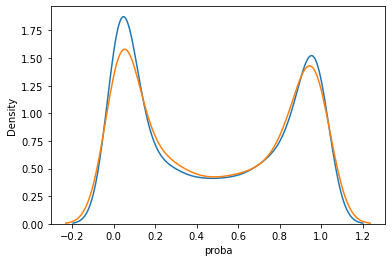

In [43]:
sns.kdeplot(data=Sn['proba'])
sns.kdeplot(data=Sv['proba'])

## SVM

In [44]:
hp = dict(C=np.arange(0.1,2,0.1),
         kernel=['linear','poly','rbf','sigmoid'],
         degree=range(2,4),
         probability=[True])

modelo = SVC()

grid = GridSearchCV(param_grid=hp,
                   cv=2,
                   scoring='accuracy',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [45]:
grid.fit(Sn[best],Sn[vart[0]])

Fitting 2 folds for each of 152 candidates, totalling 304 fits


GridSearchCV(cv=2, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                         'degree': range(2, 4),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'probability': [True]},
             scoring='accuracy', verbose=True)

In [46]:
grid.best_params_

{'C': 1.0, 'degree': 3, 'kernel': 'poly', 'probability': True}

In [47]:
modelo = grid.best_estimator_
modelo

SVC(kernel='poly', probability=True)

In [48]:
modelo.fit(Sn[best],Sn[vart[0]])

SVC(kernel='poly', probability=True)

### Validación

In [49]:
Sn['y^'] = modelo.predict(Sn[best])
Sv['y^'] = modelo.predict(Sv[best])

Sn['proba'] = modelo.predict_proba(Sn[best])[:,1]
Sv['proba'] = modelo.predict_proba(Sv[best])[:,1]

In [50]:
print(accuracy_score(y_pred=Sn['y^'],y_true=Sn[vart[0]]))
print(accuracy_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.8728448275862069
0.8670977011494253


In [51]:
print(confusion_matrix(y_pred=Sn['y^'],y_true=Sn[vart[0]]))
print(confusion_matrix(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

[[2791  476]
 [ 350 2879]]
[[1158  215]
 [ 155 1256]]


In [52]:
print(roc_auc_score(y_score=Sn['proba'],y_true=Sn[vart[0]]))
print(roc_auc_score(y_score=Sv['proba'],y_true=Sv[vart[0]]))

0.936803207616012
0.9303642744578416


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

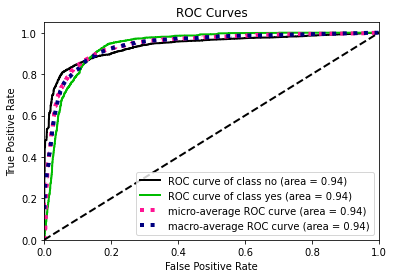

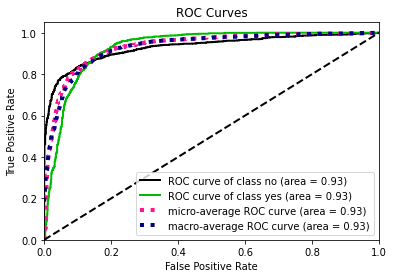

In [53]:
plot_roc(y_probas=modelo.predict_proba(Sn[best]),y_true=Sn[vart[0]])
plot_roc(y_probas=modelo.predict_proba(Sv[best]),y_true=Sv[vart[0]])

<AxesSubplot:xlabel='proba', ylabel='Density'>

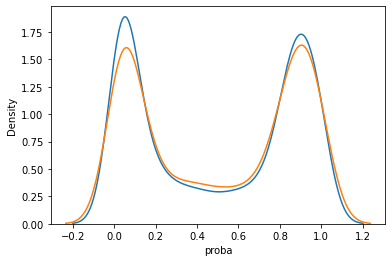

In [54]:
sns.kdeplot(data=Sn['proba'])
sns.kdeplot(data=Sv['proba'])

## LR

In [55]:
modelo = LogisticRegression(n_jobs=-1)
modelo.fit(Sn[best],Sn[vart[0]])

LogisticRegression(n_jobs=-1)

### Validación

In [56]:
Sn['y^'] = modelo.predict(Sn[best])
Sv['y^'] = modelo.predict(Sv[best])

Sn['proba'] = modelo.predict_proba(Sn[best])[:,1]
Sv['proba'] = modelo.predict_proba(Sv[best])[:,1]

In [57]:
print(accuracy_score(y_pred=Sn['y^'],y_true=Sn[vart[0]]))
print(accuracy_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.8528325123152709
0.8498563218390804


In [58]:
print(confusion_matrix(y_pred=Sn['y^'],y_true=Sn[vart[0]]))
print(confusion_matrix(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

[[2820  447]
 [ 509 2720]]
[[1174  199]
 [ 219 1192]]


In [59]:
print(roc_auc_score(y_score=Sn['proba'],y_true=Sn[vart[0]]))
print(roc_auc_score(y_score=Sv['proba'],y_true=Sv[vart[0]]))

0.9275045375723887
0.9255137167495224


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

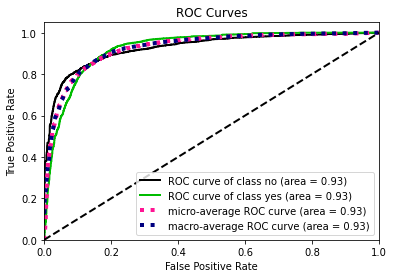

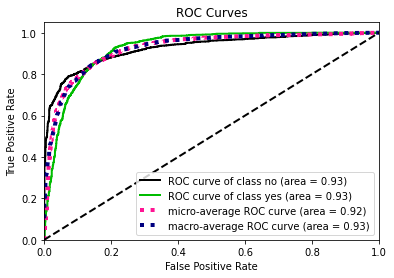

In [60]:
plot_roc(y_probas=modelo.predict_proba(Sn[best]),y_true=Sn[vart[0]])
plot_roc(y_probas=modelo.predict_proba(Sv[best]),y_true=Sv[vart[0]])

<AxesSubplot:xlabel='proba', ylabel='Density'>

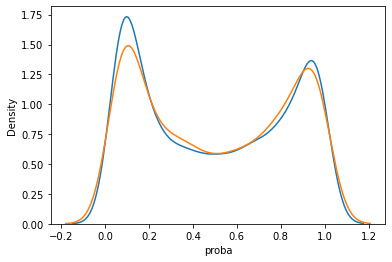

In [61]:
sns.kdeplot(data=Sn['proba'])
sns.kdeplot(data=Sv['proba'])

## Red

In [62]:
hp = dict(max_iter=[2000],
        hidden_layer_sizes=[(a,b,c) for a in range(2,3) for b in range(2,4) for c in range(2,3)],
        activation=['identity','logistic','tanh','relu'],
        solver=['sgd'],
        alpha=np.arange(0.0001,0.001,0.0001),
        learning_rate=['constant','invscaling','adaptive'])

modelo = MLPClassifier()

grid = GridSearchCV(param_grid=hp,
                   cv=2,
                   scoring='roc_auc',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [63]:
grid.fit(Sn[best],Sn[vart[0]])

Fitting 2 folds for each of 216 candidates, totalling 432 fits


GridSearchCV(cv=2, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'alpha': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'hidden_layer_sizes': [(2, 2, 2), (2, 3, 2)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [2000], 'solver': ['sgd']},
             scoring='roc_auc', verbose=True)

In [64]:
grid.best_params_

{'activation': 'tanh',
 'alpha': 0.0009000000000000001,
 'hidden_layer_sizes': (2, 3, 2),
 'learning_rate': 'constant',
 'max_iter': 2000,
 'solver': 'sgd'}

In [65]:
modelo = grid.best_estimator_
modelo

MLPClassifier(activation='tanh', alpha=0.0009000000000000001,
              hidden_layer_sizes=(2, 3, 2), max_iter=2000, solver='sgd')

In [66]:
modelo.fit(Sn[best],Sn[vart[0]])

MLPClassifier(activation='tanh', alpha=0.0009000000000000001,
              hidden_layer_sizes=(2, 3, 2), max_iter=2000, solver='sgd')

### Validación

In [67]:
Sn['y^'] = modelo.predict(Sn[best])
Sv['y^'] = modelo.predict(Sv[best])

Sn['proba'] = modelo.predict_proba(Sn[best])[:,1]
Sv['proba'] = modelo.predict_proba(Sv[best])[:,1]

In [68]:
print(accuracy_score(y_pred=Sn['y^'],y_true=Sn[vart[0]]))
print(accuracy_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.8663793103448276
0.8545258620689655


In [69]:
print(confusion_matrix(y_pred=Sn['y^'],y_true=Sn[vart[0]]))
print(confusion_matrix(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

[[2772  495]
 [ 373 2856]]
[[1139  234]
 [ 171 1240]]


In [70]:
print(roc_auc_score(y_score=Sn['proba'],y_true=Sn[vart[0]]))
print(roc_auc_score(y_score=Sv['proba'],y_true=Sv[vart[0]]))

0.9309967643817133
0.9277358781770327


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

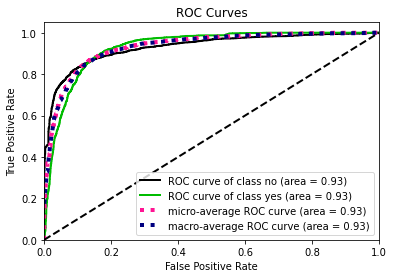

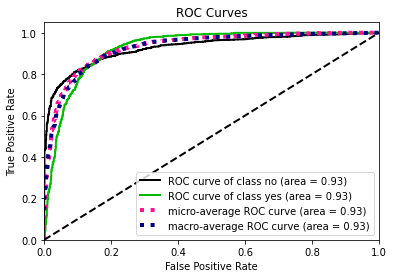

In [71]:
plot_roc(y_probas=modelo.predict_proba(Sn[best]),y_true=Sn[vart[0]])
plot_roc(y_probas=modelo.predict_proba(Sv[best]),y_true=Sv[vart[0]])

<AxesSubplot:xlabel='proba', ylabel='Density'>

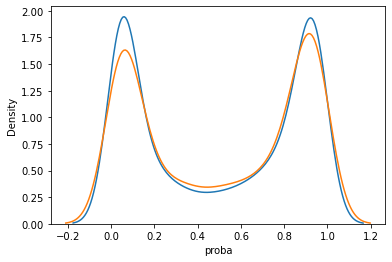

In [72]:
sns.kdeplot(data=Sn['proba'])
sns.kdeplot(data=Sv['proba'])